In [9]:
import os
import datetime
import numpy as np
import tensorflow as tf
from data.cifar import CIFAR10, CIFAR100
from model import CoTeachingModel, coteach_loss, compute_pure_ratio
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import random

def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_seed(42)

In [3]:
print_freq=100
# corruption rate, should be less than 1
noise_rate=0.5
forget_rate = None
if forget_rate is None:
    forget_rate = noise_rate

# how many epochs for linear drop rate, can be 5, 10,  15. This param is equal to Tk for R(T) in the paper.
num_gradual=10
# exponent of the forget rate, can be 0.5, 1, 2. This parameter is equal to c in Tc for R(T) in the paper.
exponent=1

# mnist, cifar10, or cifar100
dataset='cifar10'
# 'noise_type is [pairflip or symmetric]'
noise_type='symmetric'

if dataset == "cifar10":
    input_shape = [32, 32, 3]
    num_classes = 10
    epoch_decay_start = 80
    train_dataset = CIFAR10("./data/cifar10", download=True, train=True, noise_type=noise_type,
                            noise_rate=noise_rate)
    test_dataset = CIFAR10("./data/cifar10", download=True, train=False, noise_type=noise_type,
                           noise_rate=noise_rate)

elif dataset == "cifar100":
    input_shape = [32, 32, 3]
    num_classes = 100
    epoch_decay_start = 100
    train_dataset = CIFAR100("./data/cifar100", download=True, train=True, noise_type=noise_type,
                             noise_rate=noise_rate)
    test_dataset = CIFAR100("./data/cifar100", download=True, train=False, noise_type=noise_type,
                            noise_rate=noise_rate)

else:
    raise ValueError("Unsupported dataset...")


noise_or_not = train_dataset.noise_or_not

Files already downloaded and verified
Actual noise 0.50
Files already downloaded and verified


In [5]:
n_epoch=100
batch_size=128

epoch_decay_start=80
# Adjust learning rate for Adam Optimizer
learning_rate = 0.001
lr_plan = [learning_rate] * n_epoch
for i in range(epoch_decay_start, n_epoch):
    lr_plan[i] = float(n_epoch - i) / (n_epoch - epoch_decay_start) * learning_rate

# define drop rate schedule
forget_rate_schedule = np.ones(n_epoch) * forget_rate
forget_rate_schedule[:num_gradual] = np.linspace(0, forget_rate ** exponent, num_gradual)

# create training and testing batches
train_batches = train_dataset.batch_patcher(batch_size=batch_size, drop_last=True)
test_batches = test_dataset.batch_patcher(batch_size=batch_size, drop_last=True)

In [6]:
optimizer = tf.keras.optimizers.Adam()

def train_step(images, labels, lr, forget_rate):
    with tf.GradientTape(persistent=True) as tape:
        logits1, predicts1, logits2, predicts2 = coteach(images, training=True)
        acc1 = tf.reduce_mean(tf.cast(tf.equal(predicts1, tf.cast(labels, dtype=tf.int64)),
                                           dtype=tf.float32))
        acc2 = tf.reduce_mean(tf.cast(tf.equal(predicts2, tf.cast(labels, dtype=tf.int64)),
                                           dtype=tf.float32))
        # co-teaching loss
        loss1, loss2, ind1_update, ind2_update = coteach_loss(logits1, logits2, labels,
                                                                                  forget_rate)

    gradient1 = tape.gradient(loss1, coteach.cnn_model_1.trainable_variables)
    gradient2 = tape.gradient(loss2, coteach.cnn_model_2.trainable_variables)
    
    optimizer.learning_rate = lr
    optimizer.apply_gradients(zip(gradient1, coteach.cnn_model_1.trainable_variables))
    optimizer.apply_gradients(zip(gradient2, coteach.cnn_model_2.trainable_variables))
    
    # Remove TAPE to free up memory
    del tape
    return  acc1, acc2, loss1, loss2, ind1_update, ind2_update

def test_step(images, labels):
    logits1, predicts1, logits2, predicts2 = coteach(images, training=False)
    return predicts1, predicts2

In [7]:
coteach = CoTeachingModel(n_outputs=num_classes, batch_size=batch_size,
                              drop_rate=0.25, top_bn=False)

# Keep results for plotting
test_acc_results = []
label_precision_results = []
for epoch in range(1, n_epoch):
    lr = lr_plan[epoch]  # load learning rate for current epoch

    pure_ratio_1_list, pure_ratio_2_list = [], []
    train_total, train_correct1 = 0, 0
    train_total2, train_correct2 = 0, 0

    for i, (images, labels, indexes) in enumerate(train_batches):
        acc1, acc2, loss1, loss2, ind1, ind2 = train_step(images, labels, lr, forget_rate_schedule[epoch])

        pure_ratio_1, pure_ratio_2 = compute_pure_ratio(ind1, ind2, indexes, noise_or_not)
        pure_ratio_1_list.append(100 * pure_ratio_1)
        pure_ratio_2_list.append(100 * pure_ratio_2)
        train_total += 1
        train_correct1 += acc1
        train_correct2 += acc2

        if (i + 1) % print_freq == 0:
            print("Epoch [%d/%d], Iter [%d/%d], training acc1: %.4f%%, training acc2: %.4f%%, "
                  "train loss1: %.4f, train loss2: %.4f, pure_ratio_1: %.4f%%, pure_ratio_2: %.4f%%" %
                  (epoch, n_epoch, i + 1, len(train_batches), acc1 * 100.0, acc2 * 100.0, loss1, loss2,
                   sum(pure_ratio_1_list) / len(pure_ratio_1_list),
                   sum(pure_ratio_2_list) / len(pure_ratio_2_list)), flush=True)

    train_acc1 = train_correct1 / train_total * 100.0
    train_acc2 = train_correct2 / train_total * 100.0

    # testing
    print('Evaluating...')
    total, correct1, correct2 = 0, 0, 0
    for i, (images, labels, _) in enumerate(test_batches):
        pred1, pred2 = test_step(images, labels)
       
        labels = np.reshape(labels, newshape=(labels.shape[0], ))
        total += labels.shape[0]
        correct1 += np.sum(pred1 == labels)
        correct2 += np.sum(pred2 == labels)
    acc1 = 100 * float(correct1) / float(total)
    acc2 = 100 * float(correct2) / float(total)

    mean_pure_ratio1 = sum(pure_ratio_1_list) / len(pure_ratio_1_list)
    mean_pure_ratio2 = sum(pure_ratio_2_list) / len(pure_ratio_2_list)

    # End epoch
    test_acc_results.append(acc1)
    label_precision_results.append(mean_pure_ratio1)
    print('Epoch [%d/%d] Test Accuracy on the %s test images: Model1 %.4f%% Model2 %.4f%%, Pure Ratio 1 %.4f%%, '
          'Pure Ratio 2 %.4f%%\n' % (epoch, n_epoch, len(test_dataset), acc1, acc2, mean_pure_ratio1,
                                     mean_pure_ratio2), flush=True)

Epoch [1/100], Iter [100/390], training acc1: 17.1875%, training acc2: 22.6562%, train loss1: 2.1352, train loss2: 2.1104, pure_ratio_1: 52.7667%, pure_ratio_2: 52.7250%
Epoch [1/100], Iter [200/390], training acc1: 25.7812%, training acc2: 25.0000%, train loss1: 2.1078, train loss2: 2.0841, pure_ratio_1: 53.0417%, pure_ratio_2: 52.9792%
Epoch [1/100], Iter [300/390], training acc1: 24.2188%, training acc2: 28.1250%, train loss1: 1.9575, train loss2: 1.9893, pure_ratio_1: 53.4528%, pure_ratio_2: 53.3833%
Evaluating...
Epoch [1/100] Test Accuracy on the 10000 test images: Model1 34.6755% Model2 42.3578%, Pure Ratio 1 53.3077%, Pure Ratio 2 53.2671%

Epoch [2/100], Iter [100/390], training acc1: 27.3438%, training acc2: 24.2188%, train loss1: 1.9979, train loss2: 2.0376, pure_ratio_1: 56.1062%, pure_ratio_2: 56.1327%
Epoch [2/100], Iter [200/390], training acc1: 32.0312%, training acc2: 28.9062%, train loss1: 1.9162, train loss2: 1.9323, pure_ratio_1: 56.2743%, pure_ratio_2: 56.2832%
Epo

Epoch [13/100], Iter [300/390], training acc1: 50.7812%, training acc2: 51.5625%, train loss1: 0.2033, train loss2: 0.2173, pure_ratio_1: 90.5469%, pure_ratio_2: 90.5573%
Evaluating...
Epoch [13/100] Test Accuracy on the 10000 test images: Model1 74.6995% Model2 75.2504%, Pure Ratio 1 90.2845%, Pure Ratio 2 90.3365%

Epoch [14/100], Iter [100/390], training acc1: 48.4375%, training acc2: 46.0938%, train loss1: 0.2133, train loss2: 0.2366, pure_ratio_1: 90.6094%, pure_ratio_2: 90.4688%
Epoch [14/100], Iter [200/390], training acc1: 43.7500%, training acc2: 40.6250%, train loss1: 0.3578, train loss2: 0.4696, pure_ratio_1: 90.3984%, pure_ratio_2: 90.3594%
Epoch [14/100], Iter [300/390], training acc1: 48.4375%, training acc2: 46.8750%, train loss1: 0.2371, train loss2: 0.2119, pure_ratio_1: 90.6771%, pure_ratio_2: 90.6927%
Evaluating...
Epoch [14/100] Test Accuracy on the 10000 test images: Model1 75.8013% Model2 75.2604%, Pure Ratio 1 90.4367%, Pure Ratio 2 90.4247%

Epoch [15/100], Iter

Epoch [26/100], Iter [100/390], training acc1: 51.5625%, training acc2: 52.3438%, train loss1: 0.1020, train loss2: 0.2019, pure_ratio_1: 90.0312%, pure_ratio_2: 90.4375%
Epoch [26/100], Iter [200/390], training acc1: 52.3438%, training acc2: 48.4375%, train loss1: 0.0661, train loss2: 0.1535, pure_ratio_1: 90.0078%, pure_ratio_2: 90.1719%
Epoch [26/100], Iter [300/390], training acc1: 55.4688%, training acc2: 53.9062%, train loss1: 0.0166, train loss2: 0.1124, pure_ratio_1: 90.3281%, pure_ratio_2: 90.3229%
Evaluating...
Epoch [26/100] Test Accuracy on the 10000 test images: Model1 76.4824% Model2 76.1518%, Pure Ratio 1 90.0881%, Pure Ratio 2 90.0881%

Epoch [27/100], Iter [100/390], training acc1: 49.2188%, training acc2: 53.1250%, train loss1: 0.1442, train loss2: 0.0868, pure_ratio_1: 90.2812%, pure_ratio_2: 90.0625%
Epoch [27/100], Iter [200/390], training acc1: 53.9062%, training acc2: 50.7812%, train loss1: 0.0364, train loss2: 0.1381, pure_ratio_1: 90.0312%, pure_ratio_2: 89.890

Epoch [38/100], Iter [300/390], training acc1: 54.6875%, training acc2: 57.0312%, train loss1: 0.0981, train loss2: 0.1671, pure_ratio_1: 89.8646%, pure_ratio_2: 89.7448%
Evaluating...
Epoch [38/100] Test Accuracy on the 10000 test images: Model1 75.9515% Model2 76.1819%, Pure Ratio 1 89.6595%, Pure Ratio 2 89.4792%

Epoch [39/100], Iter [100/390], training acc1: 50.0000%, training acc2: 53.9062%, train loss1: 0.1407, train loss2: 0.0250, pure_ratio_1: 89.5312%, pure_ratio_2: 89.7031%
Epoch [39/100], Iter [200/390], training acc1: 51.5625%, training acc2: 53.1250%, train loss1: 0.1003, train loss2: 0.0278, pure_ratio_1: 89.5703%, pure_ratio_2: 89.6328%
Epoch [39/100], Iter [300/390], training acc1: 57.8125%, training acc2: 57.0312%, train loss1: 0.0950, train loss2: 0.0591, pure_ratio_1: 89.7969%, pure_ratio_2: 89.8490%
Evaluating...
Epoch [39/100] Test Accuracy on the 10000 test images: Model1 76.6727% Model2 75.7712%, Pure Ratio 1 89.5994%, Pure Ratio 2 89.6795%

Epoch [40/100], Iter

Epoch [51/100], Iter [100/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0450, train loss2: 0.0213, pure_ratio_1: 89.2188%, pure_ratio_2: 89.5000%
Epoch [51/100], Iter [200/390], training acc1: 53.1250%, training acc2: 53.1250%, train loss1: 0.0653, train loss2: 0.0729, pure_ratio_1: 89.1953%, pure_ratio_2: 89.3750%
Epoch [51/100], Iter [300/390], training acc1: 57.8125%, training acc2: 55.4688%, train loss1: 0.0341, train loss2: 0.0260, pure_ratio_1: 89.4323%, pure_ratio_2: 89.5729%
Evaluating...
Epoch [51/100] Test Accuracy on the 10000 test images: Model1 77.0232% Model2 76.8129%, Pure Ratio 1 89.2428%, Pure Ratio 2 89.3069%

Epoch [52/100], Iter [100/390], training acc1: 54.6875%, training acc2: 53.9062%, train loss1: 0.0307, train loss2: 0.1427, pure_ratio_1: 89.3281%, pure_ratio_2: 89.2031%
Epoch [52/100], Iter [200/390], training acc1: 53.1250%, training acc2: 53.9062%, train loss1: 0.0278, train loss2: 0.0062, pure_ratio_1: 89.1328%, pure_ratio_2: 89.117

Epoch [63/100], Iter [300/390], training acc1: 57.0312%, training acc2: 56.2500%, train loss1: 0.0091, train loss2: 0.0672, pure_ratio_1: 89.0885%, pure_ratio_2: 89.3229%
Evaluating...
Epoch [63/100] Test Accuracy on the 10000 test images: Model1 76.9231% Model2 77.4740%, Pure Ratio 1 88.8421%, Pure Ratio 2 89.0545%

Epoch [64/100], Iter [100/390], training acc1: 55.4688%, training acc2: 56.2500%, train loss1: 0.0173, train loss2: 0.0037, pure_ratio_1: 89.1562%, pure_ratio_2: 89.1406%
Epoch [64/100], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0059, train loss2: 0.0025, pure_ratio_1: 88.9609%, pure_ratio_2: 89.0000%
Epoch [64/100], Iter [300/390], training acc1: 60.1562%, training acc2: 57.8125%, train loss1: 0.0062, train loss2: 0.0432, pure_ratio_1: 89.2552%, pure_ratio_2: 89.3021%
Evaluating...
Epoch [64/100] Test Accuracy on the 10000 test images: Model1 77.0733% Model2 76.7829%, Pure Ratio 1 88.9744%, Pure Ratio 2 89.1026%

Epoch [65/100], Iter

Epoch [76/100], Iter [100/390], training acc1: 53.9062%, training acc2: 55.4688%, train loss1: 0.0627, train loss2: 0.0103, pure_ratio_1: 88.8594%, pure_ratio_2: 89.0781%
Epoch [76/100], Iter [200/390], training acc1: 53.9062%, training acc2: 53.1250%, train loss1: 0.0050, train loss2: 0.0075, pure_ratio_1: 88.6797%, pure_ratio_2: 89.0312%
Epoch [76/100], Iter [300/390], training acc1: 57.8125%, training acc2: 58.5938%, train loss1: 0.0398, train loss2: 0.0066, pure_ratio_1: 89.0052%, pure_ratio_2: 89.2344%
Evaluating...
Epoch [76/100] Test Accuracy on the 10000 test images: Model1 77.0333% Model2 78.0248%, Pure Ratio 1 88.8502%, Pure Ratio 2 89.0184%

Epoch [77/100], Iter [100/390], training acc1: 55.4688%, training acc2: 55.4688%, train loss1: 0.0119, train loss2: 0.0079, pure_ratio_1: 88.8750%, pure_ratio_2: 88.9062%
Epoch [77/100], Iter [200/390], training acc1: 53.9062%, training acc2: 53.1250%, train loss1: 0.0054, train loss2: 0.0253, pure_ratio_1: 88.8047%, pure_ratio_2: 88.875

Epoch [88/100], Iter [300/390], training acc1: 57.8125%, training acc2: 57.8125%, train loss1: 0.0003, train loss2: 0.0070, pure_ratio_1: 88.8646%, pure_ratio_2: 88.9792%
Evaluating...
Epoch [88/100] Test Accuracy on the 10000 test images: Model1 78.2953% Model2 77.9447%, Pure Ratio 1 88.6378%, Pure Ratio 2 88.7300%

Epoch [89/100], Iter [100/390], training acc1: 55.4688%, training acc2: 56.2500%, train loss1: 0.0014, train loss2: 0.0051, pure_ratio_1: 88.8438%, pure_ratio_2: 88.4688%
Epoch [89/100], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0452, train loss2: 0.1141, pure_ratio_1: 88.6562%, pure_ratio_2: 88.4531%
Epoch [89/100], Iter [300/390], training acc1: 59.3750%, training acc2: 57.0312%, train loss1: 0.0024, train loss2: 0.0128, pure_ratio_1: 88.8958%, pure_ratio_2: 88.7969%
Evaluating...
Epoch [89/100] Test Accuracy on the 10000 test images: Model1 78.4455% Model2 78.4255%, Pure Ratio 1 88.6899%, Pure Ratio 2 88.6338%

Epoch [90/100], Iter

IndexError: list index out of range

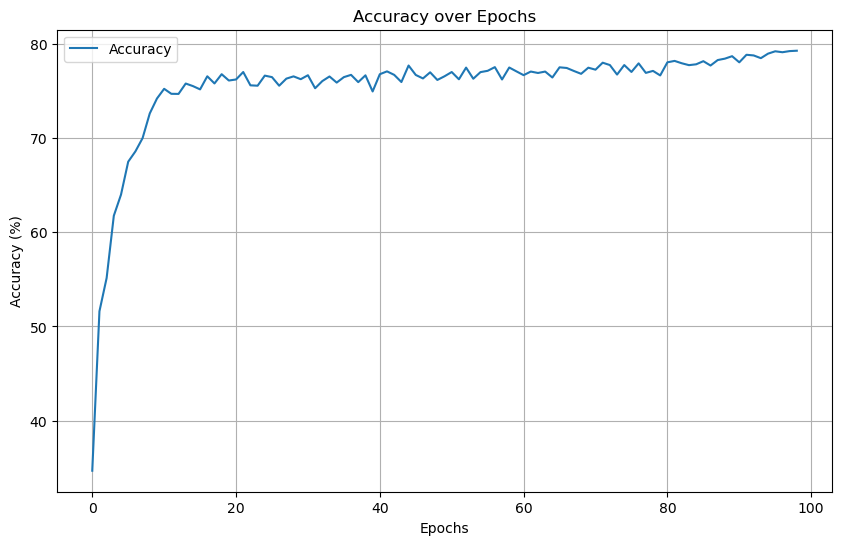

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(test_acc_results, linestyle='-', label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.legend()
plt.show()

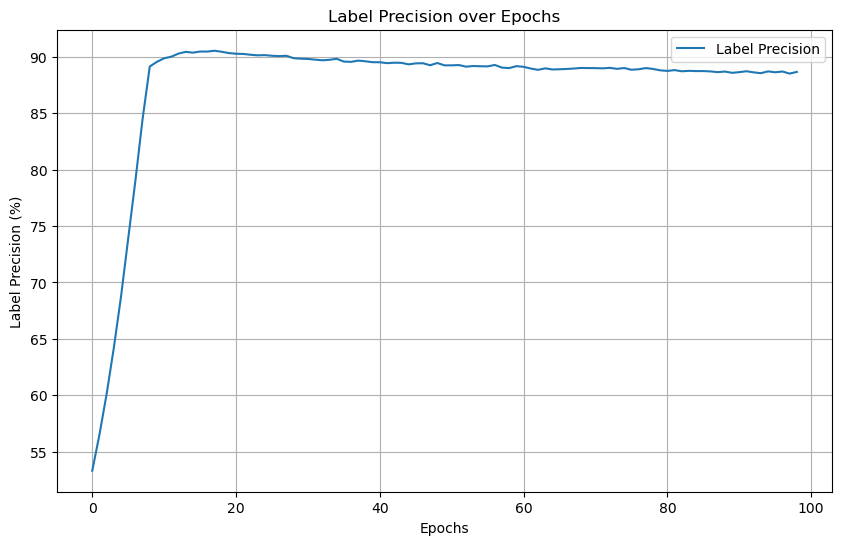

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(label_precision_results,  linestyle='-', label='Label Precision')
plt.title('Label Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Label Precision (%)')
plt.grid()
plt.legend()
plt.show()